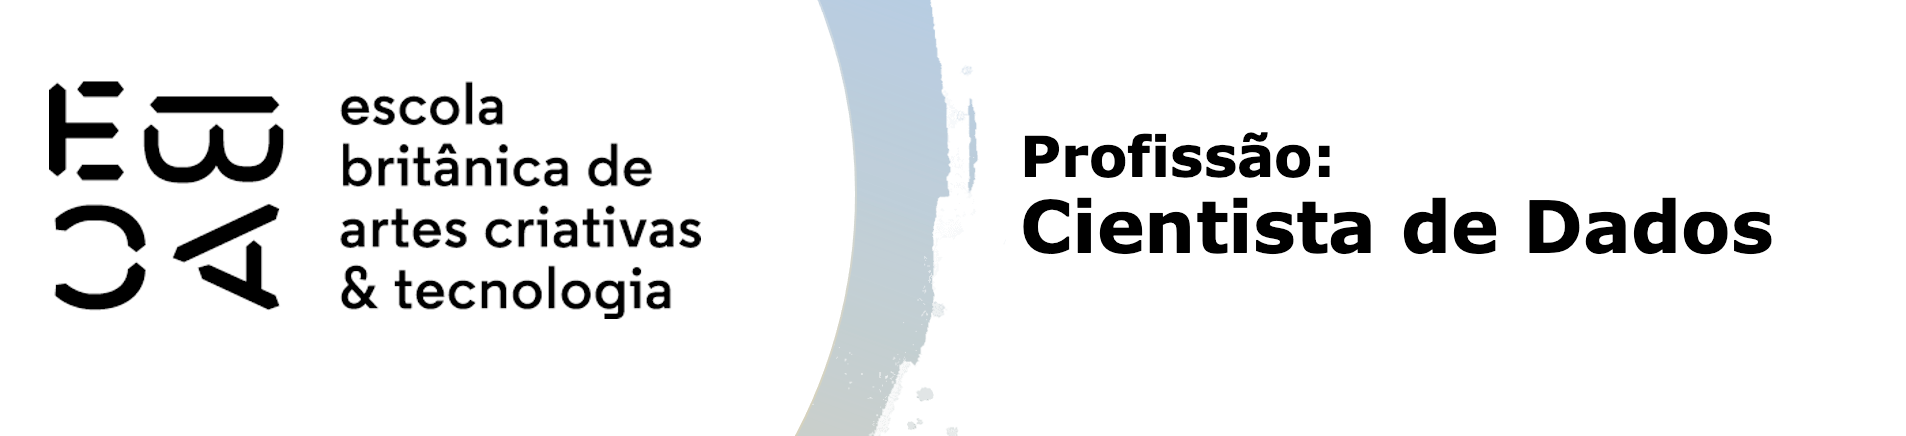

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelod e previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [20]:
import pandas as pd
import matplotlib as plt
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant



In [3]:
df = pd.read_csv('C:/Users/shinoki/Documents/data_science/tarefa_python/previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [4]:
df['data_ref'] = pd.to_datetime(df['data_ref'])
df['mes'] = df['data_ref'].dt.month


## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

In [5]:
df = df.fillna(df.mean(numeric_only=True))

In [6]:
df_modelo = df.drop(columns=['data_ref', 'index'])

df_modelo['log_renda'] = np.log(df_modelo['renda'])

df_modelo.fillna(df_modelo.mean(numeric_only=True), inplace=True)

df_dummies = pd.get_dummies(df_modelo.drop(columns=['renda', 'log_renda']), drop_first=True)

X = df_dummies
y = df_modelo['log_renda']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [7]:
y_pred = model.predict(X_test)

residuos = y_test - y_pred


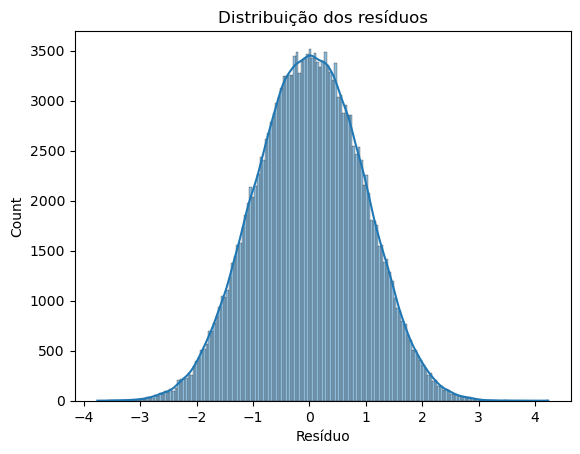

In [8]:
sns.histplot(residuos, kde=True)
plt.title("Distribuição dos resíduos")
plt.xlabel("Resíduo")
plt.show()

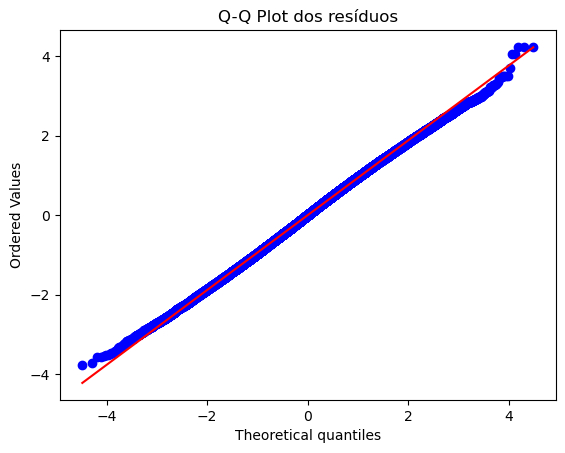

In [9]:
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Q-Q Plot dos resíduos")
plt.show()


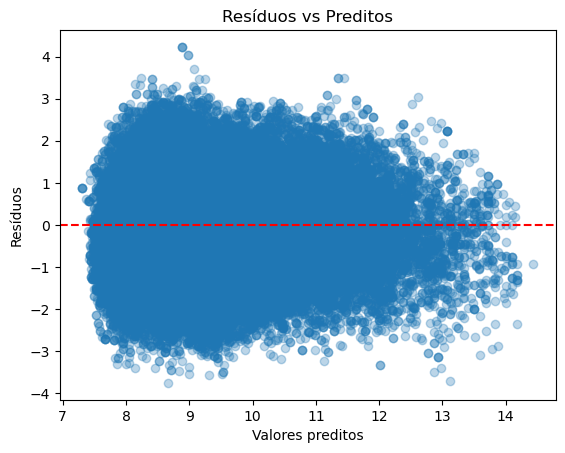

In [10]:
plt.scatter(y_pred, residuos, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores preditos")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Preditos")
plt.show()


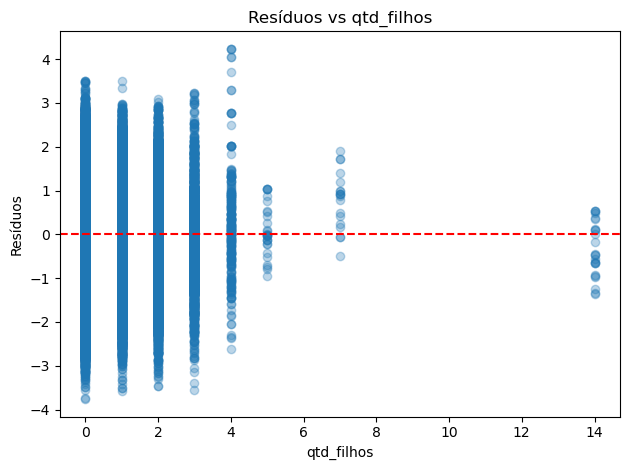

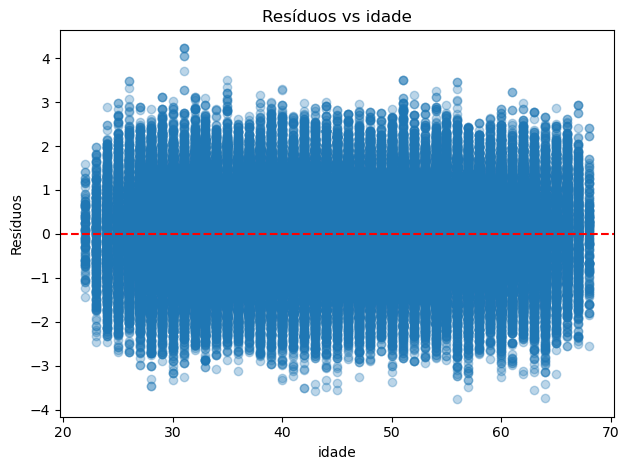

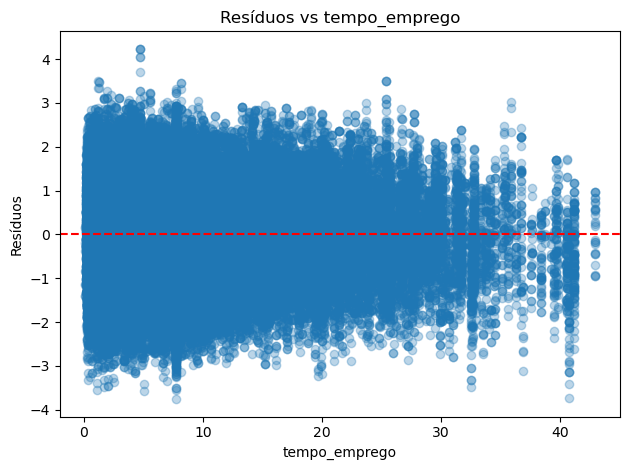

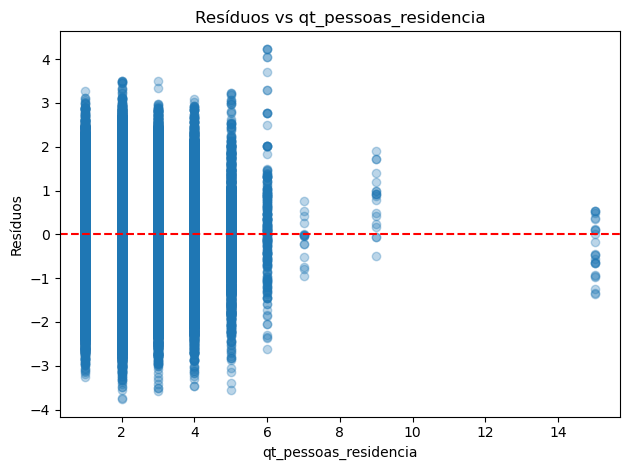

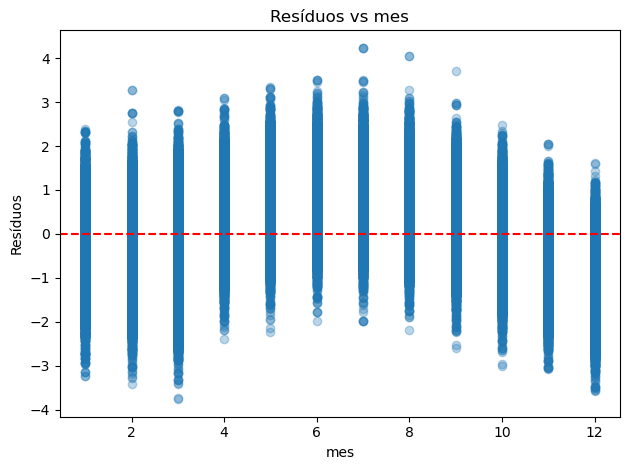

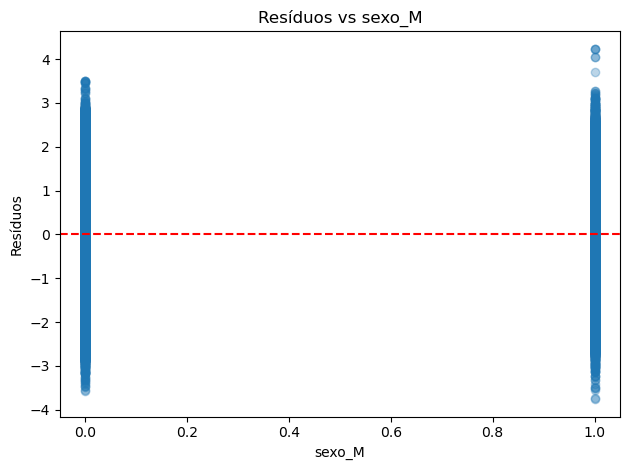

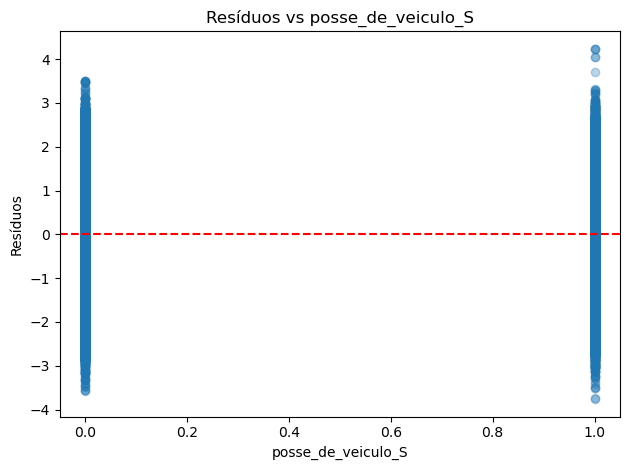

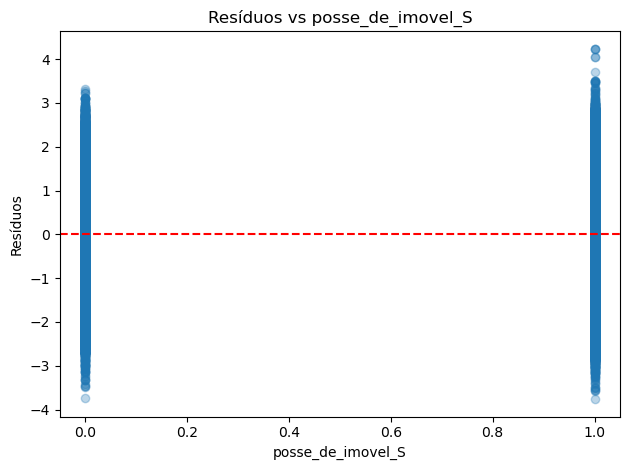

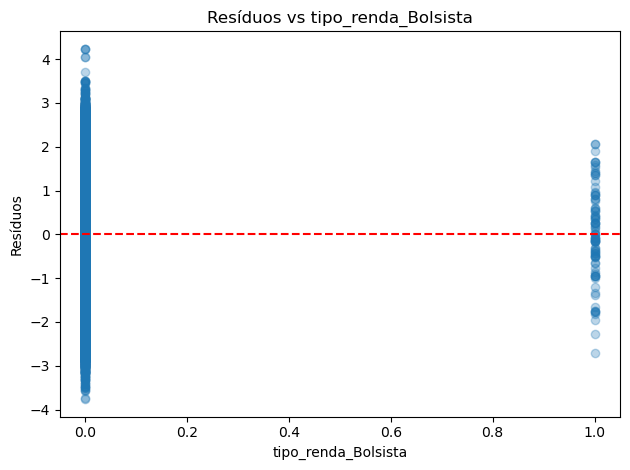

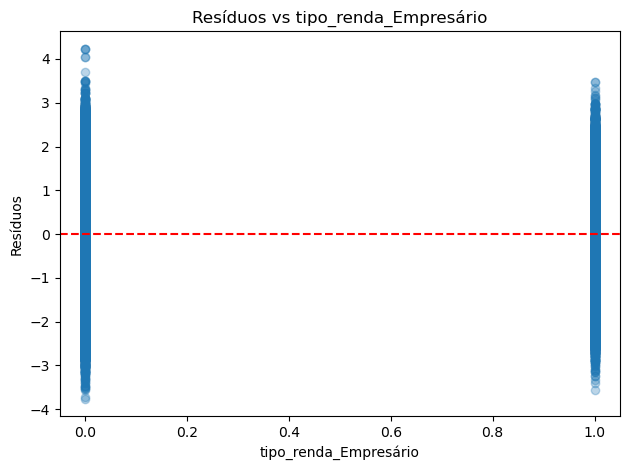

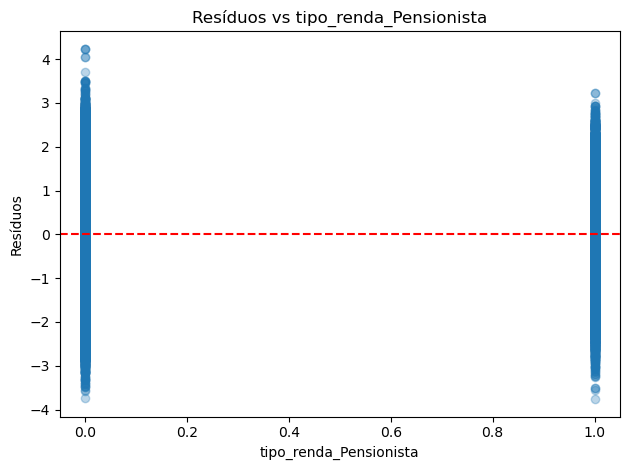

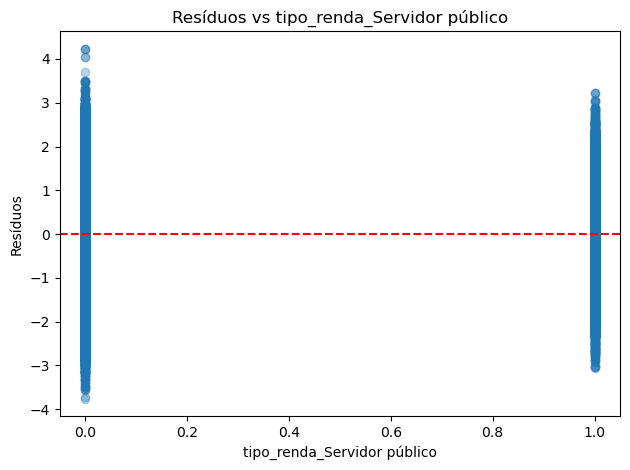

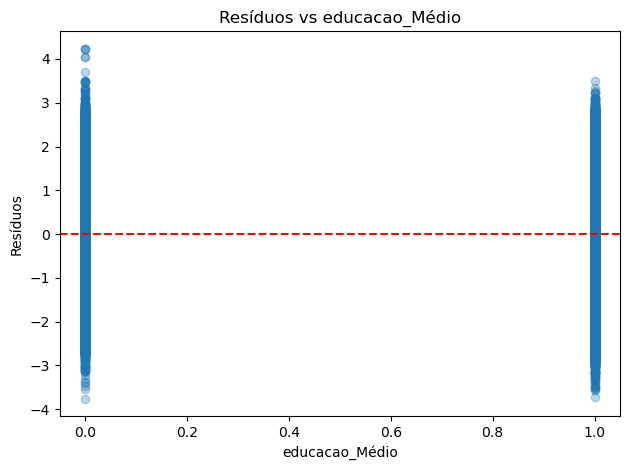

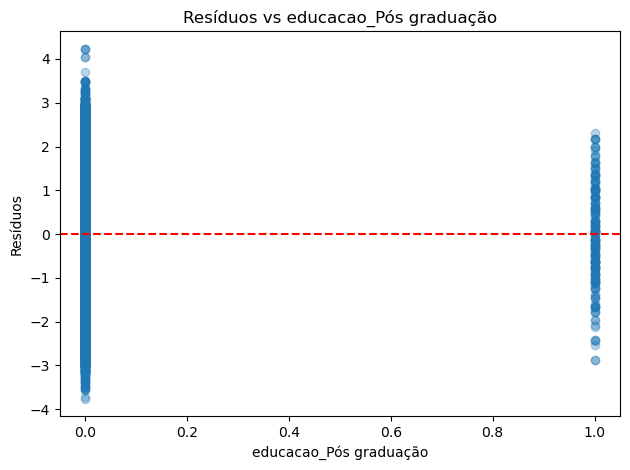

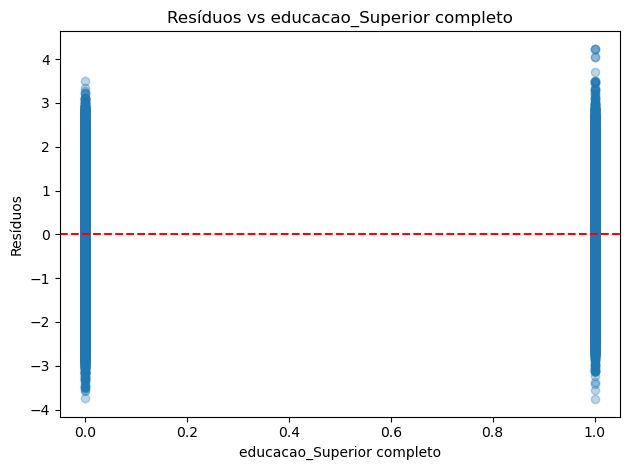

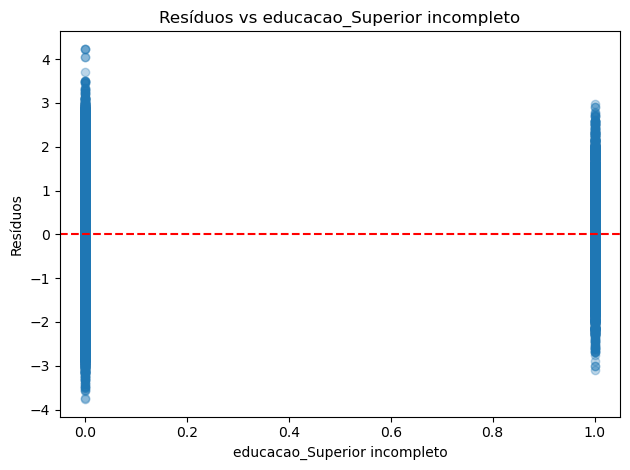

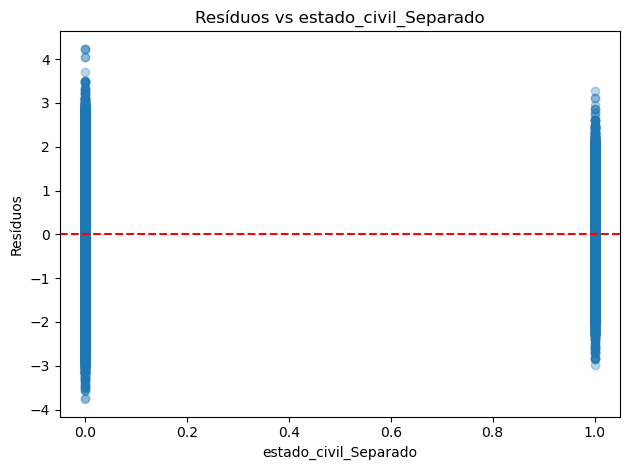

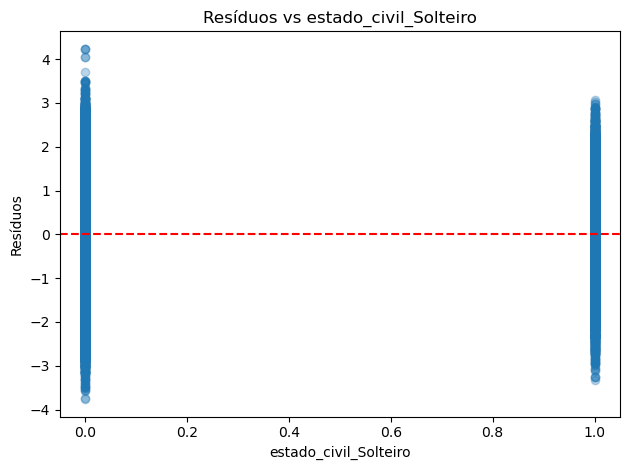

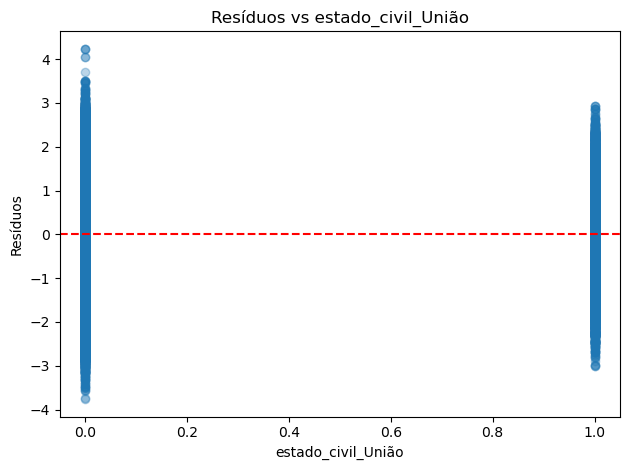

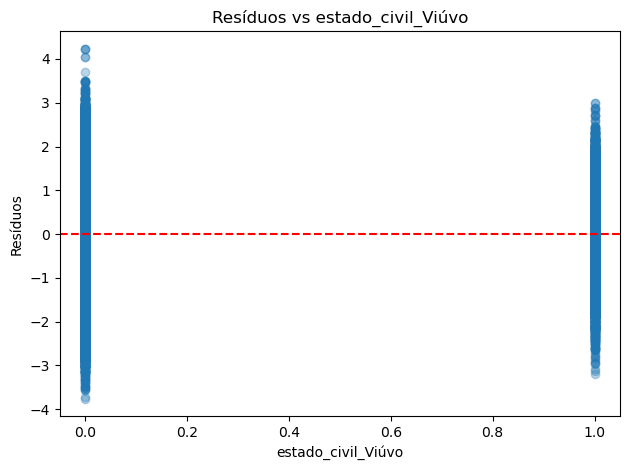

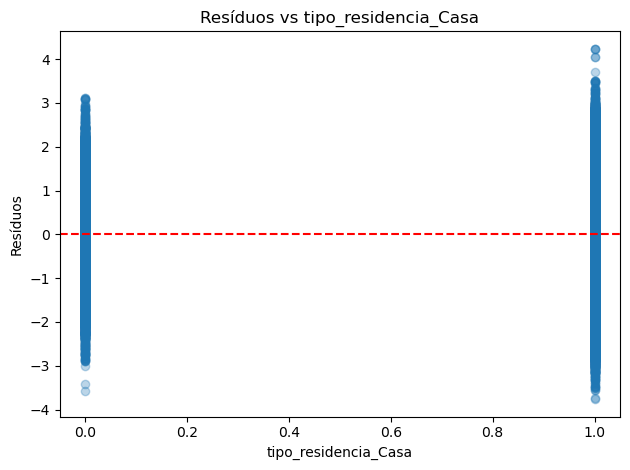

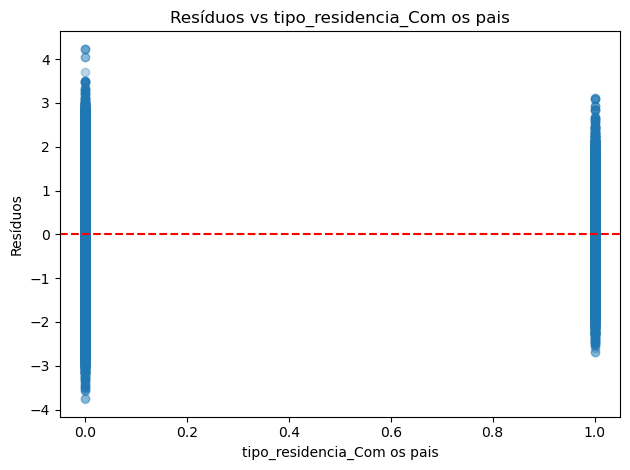

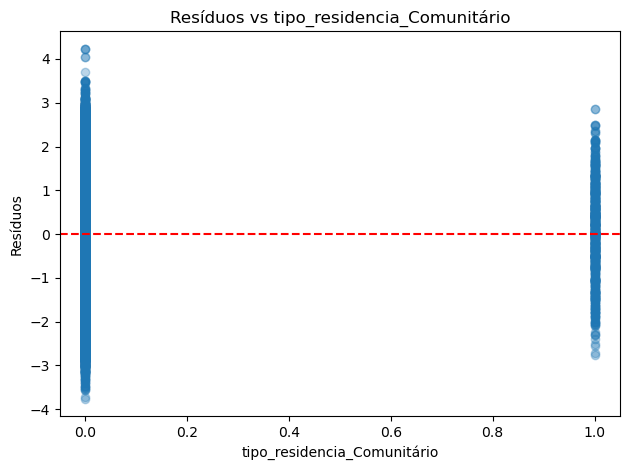

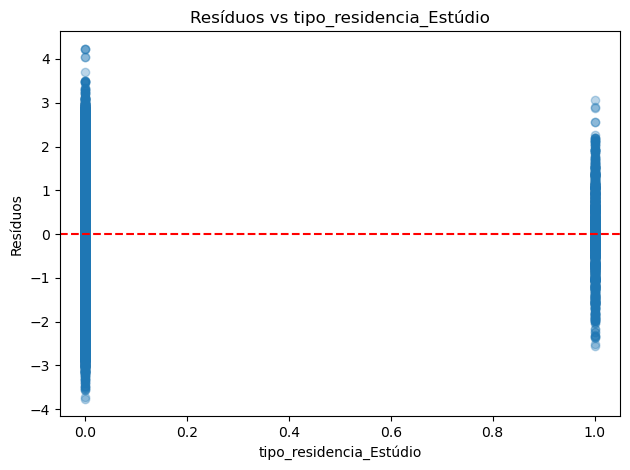

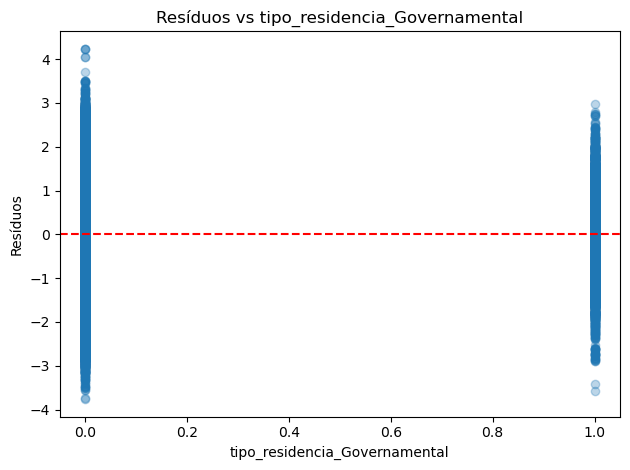

In [11]:
for col in X_test.columns:
    plt.figure()
    plt.scatter(X_test[col], residuos, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Resíduos vs {col}")
    plt.xlabel(col)
    plt.ylabel("Resíduos")
    plt.tight_layout()
    plt.show()


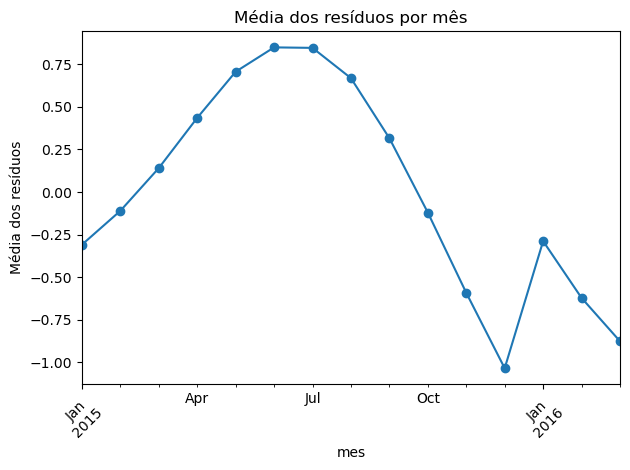

In [12]:
df['data_ref'] = pd.to_datetime(df['data_ref'])

df_test = X_test.copy()
df_test['residuos'] = residuos.values
df_test['data_ref'] = df.loc[X_test.index, 'data_ref']

df_test['mes'] = df_test['data_ref'].dt.to_period('M')
media_residuos_mes = df_test.groupby('mes')['residuos'].mean()

media_residuos_mes.plot(marker='o')
plt.title("Média dos resíduos por mês")
plt.ylabel("Média dos resíduos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


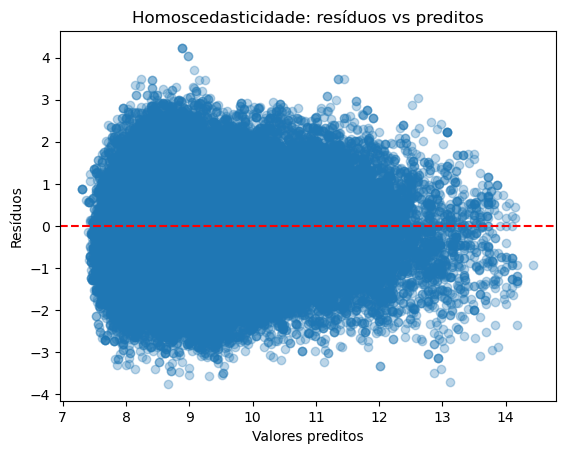

In [13]:
plt.scatter(y_pred, residuos, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores preditos")
plt.ylabel("Resíduos")
plt.title("Homoscedasticidade: resíduos vs preditos")
plt.show()

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [ ]:
# Os resíduos aparentam seguir uma distribuição aproximadamente normal, com poucos pontos fora do intervalo ±3 nos studentized residuals — indicando presença de possíveis outliers. O gráfico de leverage versus residuals sugere que algumas observações têm influência moderada. Em geral, não há indícios de grande impacto nos resultados, mas essas observações podem justificar análise adicional ou modelos mais robustos.

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

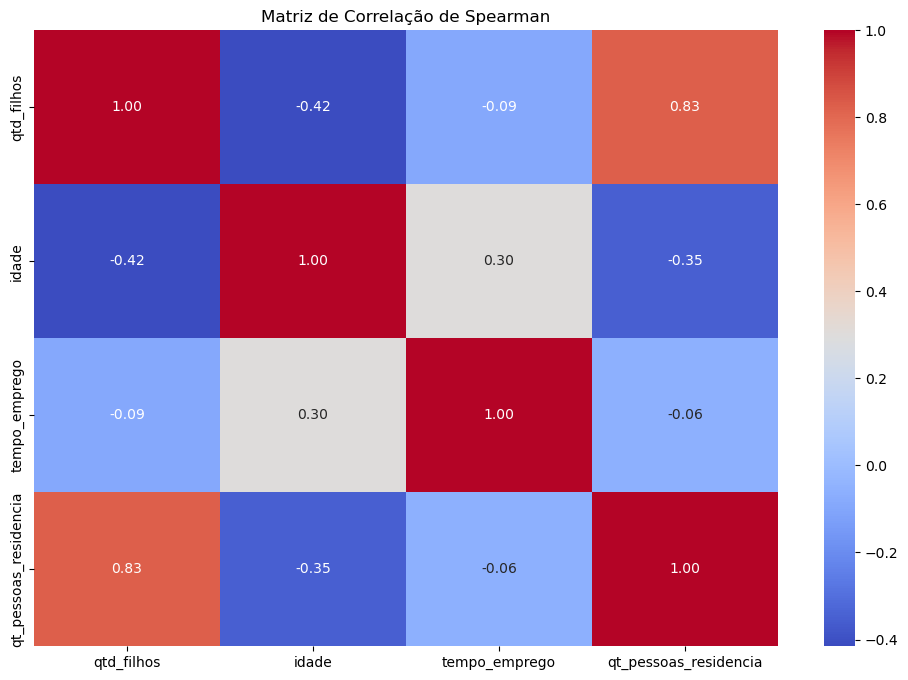

In [17]:
X = df.drop(columns=['data_ref', 'index', 'renda', 'mes'])  

X_numericas = X.select_dtypes(include='number')

plt.figure(figsize=(12, 8))
sns.heatmap(X_numericas.corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação de Spearman")
plt.show()

In [19]:
X = df.drop(columns=['data_ref', 'index', 'renda', 'mes'])  
X_numericas = X.select_dtypes(include='number')

X_vif = add_constant(X_numericas)

vif_data = pd.DataFrame()
vif_data["Variável"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)

                Variável        VIF
0                  const  39.992182
1             qtd_filhos   4.944076
2                  idade   1.232818
3          tempo_emprego   1.068189
4  qt_pessoas_residencia   4.827534


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

In [21]:
X_treino_original = X_train[['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia']]
X_teste_original = X_test[['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia']]

modelo_original = LinearRegression()
modelo_original.fit(X_treino_original, y_train)

y_pred_original = modelo_original.predict(X_teste_original)

X_treino_ajustado = X_train[['idade', 'tempo_emprego']] 
X_teste_ajustado = X_test[['idade', 'tempo_emprego']]

modelo_ajustado = LinearRegression()
modelo_ajustado.fit(X_treino_ajustado, y_train)

y_pred_ajustado = modelo_ajustado.predict(X_teste_ajustado)

def avaliar_modelo(y_true, y_pred, nome_modelo):
    print(f"\n--- {nome_modelo} ---")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²:", r2_score(y_true, y_pred))

avaliar_modelo(y_test, y_pred_original, "Modelo Original")
avaliar_modelo(y_test, y_pred_ajustado, "Modelo Ajustado")


--- Modelo Original ---
MAE: 0.8234391516984172
RMSE: 1.0142274488307892
R²: 0.37633999601656043

--- Modelo Ajustado ---
MAE: 0.8234725085498894
RMSE: 1.014264010577973
R²: 0.3762950307369961
